In [1]:
import sys
print(sys.executable)

# %ls

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os, glob

# plot figsize settings
small_plt = [3,3]
med_plt = [6,6]
big_plt = [9,9]
short_plt = [14,3]
wide_plt = [14,9]

C:\Users\OttoP\.conda\envs\ADTA\python.exe
 Volume in drive C has no label.
 Volume Serial Number is E25D-EE92

 Directory of C:\Users\OttoP\Desktop\Python Workbooks\adta5410\challenge4

07/07/2025  03:47 PM    <DIR>          .
07/07/2025  03:44 PM    <DIR>          ..
07/07/2025  03:48 PM    <DIR>          .ipynb_checkpoints
07/06/2025  06:44 PM           470,837 Brittney weekly_challenge_4_Plots.ipynb
07/03/2025  11:56 PM        68,474,148 CLEANED_synthetic_ecommerce_2025-06-13_Version2.csv
07/04/2025  12:12 PM        11,377,439 Otto_CLV_preprocessing.ipynb
07/05/2025  12:22 AM         1,379,372 revised_CLV_outliersremoved.ipynb
               4 File(s)     81,701,796 bytes
               3 Dir(s)  100,160,299,008 bytes free


In [76]:
df = pd.read_csv("CLEANED_synthetic_ecommerce_2025-06-13_Version2.csv")
print(df.info())
print(df.head())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_id               300000 non-null  int64  
 1   signup_date               300000 non-null  object 
 2   last_activity_ts          300000 non-null  object 
 3   recency_days              300000 non-null  int64  
 4   total_spend_12m           300000 non-null  float64
 5   avg_basket_value          300000 non-null  float64
 6   sessions_90d              300000 non-null  int64  
 7   days_since_last_purchase  300000 non-null  int64  
 8   items_per_order           300000 non-null  int64  
 9   loyalty_points            300000 non-null  float64
 10  returns_12m               300000 non-null  int64  
 11  site_search_rate          300000 non-null  float64
 12  email_open_rate           300000 non-null  float64
 13  discount_pct_last_order   300000 non-null  f

In [77]:
# import country codes
cols = ['ISO3166-1-Alpha-2', 'Region Name']
country_codes = pd.read_csv('country-codes.csv', usecols=cols)
cols_rename={'ISO3166-1-Alpha-2': 'country_code', 'Region Name': 'region_name'}
country_codes = country_codes.rename(columns=cols_rename)


In [78]:
country_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country_code  248 non-null    object
 1   region_name   248 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


In [79]:
country_codes.isna().sum()

country_code    1
region_name     1
dtype: int64

In [80]:
country_codes = country_codes.dropna()

In [81]:
country_codes

,country_code,region_name
0,AF,Asia
1,AX,Europe
2,AL,Europe
3,DZ,Africa
4,AS,Oceania
...,...,...
244,WF,Oceania
245,EH,Africa
246,YE,Asia
247,ZM,Africa


In [82]:
# add country region and continent to dataset
df = pd.merge(df, country_codes, on='country_code', how='left')
df = df.drop(columns='bool_ATBO', axis=1)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_id               300000 non-null  int64  
 1   signup_date               300000 non-null  object 
 2   last_activity_ts          300000 non-null  object 
 3   recency_days              300000 non-null  int64  
 4   total_spend_12m           300000 non-null  float64
 5   avg_basket_value          300000 non-null  float64
 6   sessions_90d              300000 non-null  int64  
 7   days_since_last_purchase  300000 non-null  int64  
 8   items_per_order           300000 non-null  int64  
 9   loyalty_points            300000 non-null  float64
 10  returns_12m               300000 non-null  int64  
 11  site_search_rate          300000 non-null  float64
 12  email_open_rate           300000 non-null  float64
 13  discount_pct_last_order   300000 non-null  f

df.to_csv('CLV_revised.csv')

In [84]:
# isolate numeric dtypes
df_num = df.drop(['customer_id'], axis=1).select_dtypes(include='number')

spend_cols = ['total_spend_12m', 'avg_basket_value', 'clv_3yr_usd']
purch_cols = ['days_since_last_purchase', 'items_per_order', 'returns_12m', 'total_orders_12m', 'avg_time_between_orders']
cons_cols = ['recency_days', 'sessions_90d', 'site_search_rate', 'email_open_rate', 'discount_pct_last_order', 'loyalty_points']

all_cols = spend_cols + purch_cols + cons_cols

# df_num[all_cols]

In [85]:
# Check the distributions of numeric features to determine outlier detection method

"""
Function that creates hist and box plots for a feature
"""
# create a function to display plots
def plots(data, columns):
    for i in data[columns]:
        plt.figure(figsize=[14,3])
        plt.subplot(1, 2, 1)
        sns.histplot(data, x=i, kde=True, bins=30)
        plt.title(f'{i} Distribution')
        plt.subplot(1, 2, 2)
        sns.boxplot(data, y=i)
        plt.xlabel(f'{i}')
        plt.title(f'{i} Boxplot')
        plt.show()

# checking for outliers
# develop a function to check the IQR


"""
Function that evaluates series for both IQR and MAD outlier methods
"""
# outlier detector functions returns boolean
def outlier_flag(data, column):
    series = data[column]
    def flag_outliers_iqr(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return (series < lower_bound) | (series > upper_bound)
    
    def flag_outliers_mad(series, threshold=3):
        median = series.median()
        abs_deviation = np.abs(series - median)
        mad = abs_deviation.median()
        outlier_threshold = threshold * mad
        return abs_deviation > outlier_threshold
        
    data[f'IQR_{column}'] = flag_outliers_iqr(series)
    data[f'MAD_{column}'] = flag_outliers_mad(series)
    return data

"""
Function to isolate outliers for analysis
"""
# outlier detector functions. Returns DataFrames
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

def detect_outliers_mad(data, column, threshold=3):
    median = data[column].median()
    abs_deviation = np.abs(data[column] - median)
    mad = abs_deviation.median()
    outlier_threshold = threshold * mad
    outliers = data[abs_deviation > outlier_threshold]
    return outliers

"""
Function to remove outliers from the Data
"""
# outlier removal functions
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_removed = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return outliers_removed

def remove_outliers_mad(data, column, threshold=3):
    median = data[column].median()
    abs_deviation = np.abs(data[column] - median)
    mad = abs_deviation.median()
    outlier_threshold = threshold * mad
    outliers_removed = data[abs_deviation < outlier_threshold]
    return outliers_removed

"""
Function that adds additional statistics to .describe()
"""
def desc_ex(df):
    num = df.select_dtypes(include='number')

    desc = df.describe()

    median = pd.Series(num.median(), name='median')
    skew = pd.Series(num.skew(), name='skewness')
    kurt = pd.Series(num.kurtosis(), name='kurtosis')
    cv = pd.Series(num.std() / num.mean(), name='coefficient_of_variation')

    add_stats = pd.DataFrame([median, skew, kurt, cv])
    ex_stats = pd.concat([desc, add_stats])
    return ex_stats

In [86]:
desc_ex(df_num[all_cols])

,total_spend_12m,avg_basket_value,clv_3yr_usd,days_since_last_purchase,items_per_order,returns_12m,total_orders_12m,avg_time_between_orders,recency_days,sessions_90d,site_search_rate,email_open_rate,discount_pct_last_order,loyalty_points
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,6194.101341,50.081100,6900.419667,29.965033,4.000120,2.000243,66.333653,13.088845,679.856327,2.937477,0.285783,0.275968,9.999802,499.949783
std,11169.398333,19.819220,12289.212628,29.913803,1.731788,1.417447,287.251192,17.168165,599.398069,7.279116,0.159940,0.155528,4.948754,22.310618
min,9.840000,5.000000,116.630000,0.000000,1.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000289,0.000000,0.000000,407.000000
25%,1323.002500,36.480000,1578.235000,9.000000,3.000000,1.000000,0.000000,4.740000,184.000000,0.000000,0.161185,0.169322,6.551370,485.000000
50%,2975.475000,49.990000,3389.295000,21.000000,4.000000,2.000000,0.000000,9.100000,509.000000,0.000000,0.264657,0.270496,9.968305,500.000000
75%,6705.050000,63.500000,7472.862500,42.000000,5.000000,3.000000,44.000000,15.800000,1039.000000,0.000000,0.389466,0.379674,13.359288,515.000000
max,694278.250000,136.710000,744597.890000,412.000000,15.000000,12.000000,33567.000000,376.400000,2711.000000,41.000000,0.932675,0.927149,33.240327,608.000000
median,2975.475000,49.990000,3389.295000,21.000000,4.000000,2.000000,0.000000,9.100000,509.000000,0.000000,0.264657,0.270496,9.968305,500.000000
skewness,9.495705,0.075930,9.694542,1.991792,0.573152,0.711049,26.991558,7.415844,0.972045,2.226975,0.596871,0.204215,0.118646,0.047155


In [ ]:
# spend behavior plots
# plots(df_num, spend_cols)

In [ ]:
# purchase behavior plots
# plots(df_num, purch_cols)

In [ ]:
# consumer behavior plots
# plots(df_num, cons_cols)

In [87]:
df_outliers = df_num.copy()

skew_map = df_outliers[all_cols].apply(lambda i: i.skew())
method_map = skew_map.apply(lambda i: 'MAD' if abs(i) > 2 else 'IQR')

for col in all_cols:
    df_outliers = outlier_flag(df_outliers, col)


flag_cols = [i for i in df_outliers.columns if i.startswith('IQR_') or i.startswith('MAD_')]
outlier_flags_df = df_outliers[flag_cols]

In [88]:
method_map

total_spend_12m             MAD
avg_basket_value            IQR
clv_3yr_usd                 MAD
days_since_last_purchase    IQR
items_per_order             IQR
returns_12m                 IQR
total_orders_12m            MAD
avg_time_between_orders     MAD
recency_days                IQR
sessions_90d                MAD
site_search_rate            IQR
email_open_rate             IQR
discount_pct_last_order     IQR
loyalty_points              IQR
dtype: object

In [89]:
melt_df = outlier_flags_df.melt(var_name='feature name', value_name='is outlier')

pivot_table = pd.pivot_table(
    melt_df,
    index='feature name',
    columns='is outlier',
    aggfunc='size',
    fill_value=0
).rename(columns={False: 'Not Outlier', True: 'Outlier'}).map(lambda i: f"{i:,}")

pivot_table

is outlier,Not Outlier,Outlier
feature name,,
IQR_avg_basket_value,"298,939","1,061"
IQR_avg_time_between_orders,"279,870","20,130"
IQR_clv_3yr_usd,"272,415","27,585"
IQR_days_since_last_purchase,"285,913","14,087"
IQR_discount_pct_last_order,"298,942","1,058"
IQR_email_open_rate,"298,683","1,317"
IQR_items_per_order,"296,372","3,628"
IQR_loyalty_points,"297,944","2,056"
IQR_recency_days,"296,606","3,394"


In [16]:
%who_ls DataFrame

['country_codes',
 'df',
 'df_num',
 'df_outliers',
 'melt_df',
 'outlier_flags_df',
 'pivot_table']

In [91]:
df_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   recency_days                  300000 non-null  int64  
 1   total_spend_12m               300000 non-null  float64
 2   avg_basket_value              300000 non-null  float64
 3   sessions_90d                  300000 non-null  int64  
 4   days_since_last_purchase      300000 non-null  int64  
 5   items_per_order               300000 non-null  int64  
 6   loyalty_points                300000 non-null  float64
 7   returns_12m                   300000 non-null  int64  
 8   site_search_rate              300000 non-null  float64
 9   email_open_rate               300000 non-null  float64
 10  discount_pct_last_order       300000 non-null  float64
 11  total_orders_12m              300000 non-null  int64  
 12  avg_time_between_orders       300000 non-nul

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_id               300000 non-null  int64  
 1   signup_date               300000 non-null  object 
 2   last_activity_ts          300000 non-null  object 
 3   recency_days              300000 non-null  int64  
 4   total_spend_12m           300000 non-null  float64
 5   avg_basket_value          300000 non-null  float64
 6   sessions_90d              300000 non-null  int64  
 7   days_since_last_purchase  300000 non-null  int64  
 8   items_per_order           300000 non-null  int64  
 9   loyalty_points            300000 non-null  float64
 10  returns_12m               300000 non-null  int64  
 11  site_search_rate          300000 non-null  float64
 12  email_open_rate           300000 non-null  float64
 13  discount_pct_last_order   300000 non-null  f

In [98]:
df['MAD_clv_3yr_usd'] = df_outliers['MAD_clv_3yr_usd']
df['spend_tier'] = pd.qcut(df['total_spend_12m'], q=3, labels=['Low', 'Medium', 'High'])

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   customer_id               300000 non-null  int64   
 1   signup_date               300000 non-null  object  
 2   last_activity_ts          300000 non-null  object  
 3   recency_days              300000 non-null  int64   
 4   total_spend_12m           300000 non-null  float64 
 5   avg_basket_value          300000 non-null  float64 
 6   sessions_90d              300000 non-null  int64   
 7   days_since_last_purchase  300000 non-null  int64   
 8   items_per_order           300000 non-null  int64   
 9   loyalty_points            300000 non-null  float64 
 10  returns_12m               300000 non-null  int64   
 11  site_search_rate          300000 non-null  float64 
 12  email_open_rate           300000 non-null  float64 
 13  discount_pct_last_order   300

In [109]:
%pwd

'C:\\Users\\OttoP\\Desktop\\Python Workbooks\\adta5410\\challenge4'

In [113]:
df.to_csv('CLV_revised.csv', index=False)

In [115]:
testx = pd.read_csv('CLV_revised.csv')
testx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_id               300000 non-null  int64  
 1   signup_date               300000 non-null  object 
 2   last_activity_ts          300000 non-null  object 
 3   recency_days              300000 non-null  int64  
 4   total_spend_12m           300000 non-null  float64
 5   avg_basket_value          300000 non-null  float64
 6   sessions_90d              300000 non-null  int64  
 7   days_since_last_purchase  300000 non-null  int64  
 8   items_per_order           300000 non-null  int64  
 9   loyalty_points            300000 non-null  float64
 10  returns_12m               300000 non-null  int64  
 11  site_search_rate          300000 non-null  float64
 12  email_open_rate           300000 non-null  float64
 13  discount_pct_last_order   300000 non-null  f

In [116]:
testx.describe()

,customer_id,recency_days,total_spend_12m,avg_basket_value,sessions_90d,days_since_last_purchase,items_per_order,loyalty_points,returns_12m,site_search_rate,email_open_rate,discount_pct_last_order,total_orders_12m,avg_time_between_orders,clv_3yr_usd
count,300000.000000,300000.000000,300000.000000,300000.00000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,150000.500000,679.856327,6194.101341,50.08110,2.937477,29.965033,4.000120,499.949783,2.000243,0.285783,0.275968,9.999802,66.333653,13.088845,6900.419667
std,86602.684716,599.398069,11169.398333,19.81922,7.279116,29.913803,1.731788,22.310618,1.417447,0.159940,0.155528,4.948754,287.251192,17.168165,12289.212628
min,1.000000,0.000000,9.840000,5.00000,0.000000,0.000000,1.000000,407.000000,0.000000,0.000289,0.000000,0.000000,0.000000,0.100000,116.630000
25%,75000.750000,184.000000,1323.002500,36.48000,0.000000,9.000000,3.000000,485.000000,1.000000,0.161185,0.169322,6.551370,0.000000,4.740000,1578.235000
50%,150000.500000,509.000000,2975.475000,49.99000,0.000000,21.000000,4.000000,500.000000,2.000000,0.264657,0.270496,9.968305,0.000000,9.100000,3389.295000
75%,225000.250000,1039.000000,6705.050000,63.50000,0.000000,42.000000,5.000000,515.000000,3.000000,0.389466,0.379674,13.359288,44.000000,15.800000,7472.862500
max,300000.000000,2711.000000,694278.250000,136.71000,41.000000,412.000000,15.000000,608.000000,12.000000,0.932675,0.927149,33.240327,33567.000000,376.400000,744597.890000


<Axes: xlabel='spend_tier', ylabel='clv_3yr_usd'>

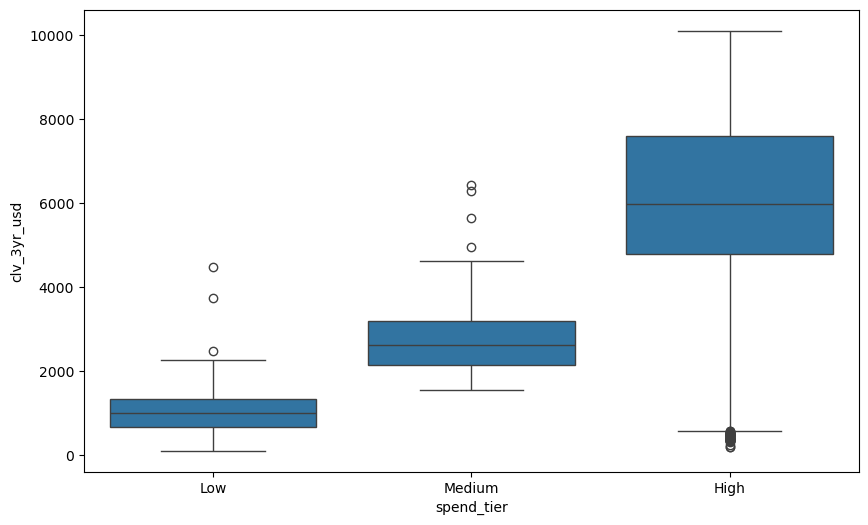

In [101]:
# CLV by Spend tier and Sessions
plt.figure(figsize=(10,6))
df_MAD = df_outliers.loc[df_outliers['MAD_clv_3yr_usd'] == False].copy()
df_MAD['spend_tier'] = pd.qcut(df_MAD['total_spend_12m'], q=3, labels=['Low', 'Medium', 'High'])
sns.boxplot(x='spend_tier', y='clv_3yr_usd', data=df_MAD)



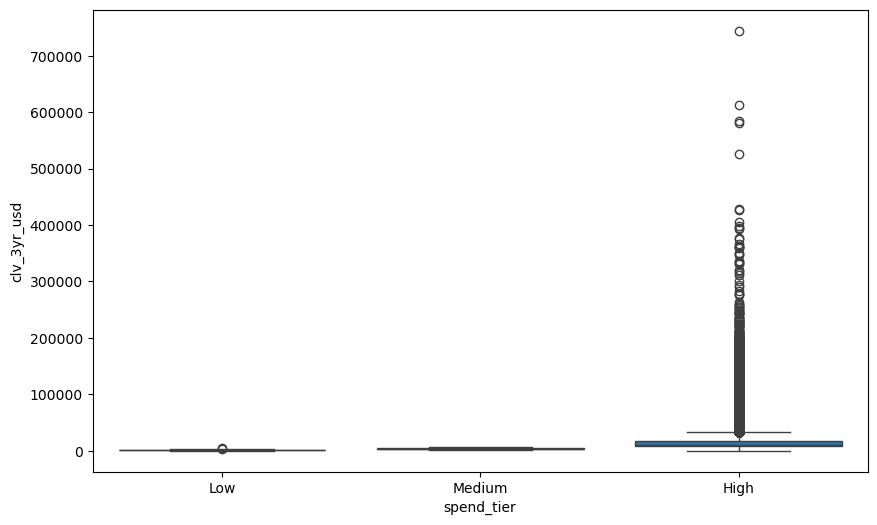

In [100]:
plt.figure(figsize=(10,6))
sns.boxplot(x='spend_tier', y='clv_3yr_usd', data=df)
# sns.stripplot(x='spend_tier', y='clv_3yr_usd', data=df, color='grey', alpha=0.3, jitter=True)
# plt.yscale('log')
plt.show()

300000

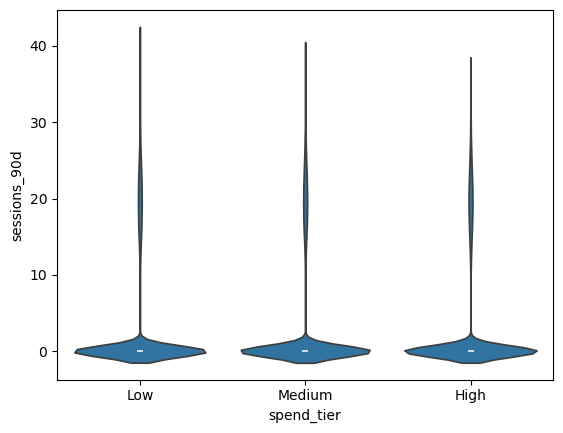

In [105]:
# Violin plot Sessions vs CLV
sns.violinplot(x='spend_tier', y='sessions_90d', data=df_MAD)

<Axes: xlabel='spend_tier', ylabel='email_open_rate'>

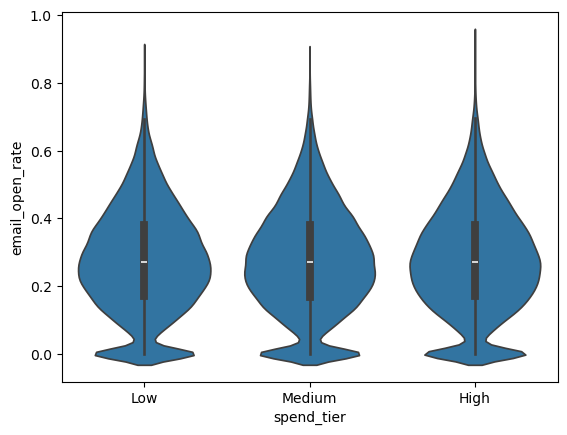

In [108]:
# Violin plot Sessions vs CLV
sns.violinplot(x='spend_tier', y='email_open_rate', data=df_MAD)

<Axes: xlabel='total_orders_12m', ylabel='total_spend_12m'>

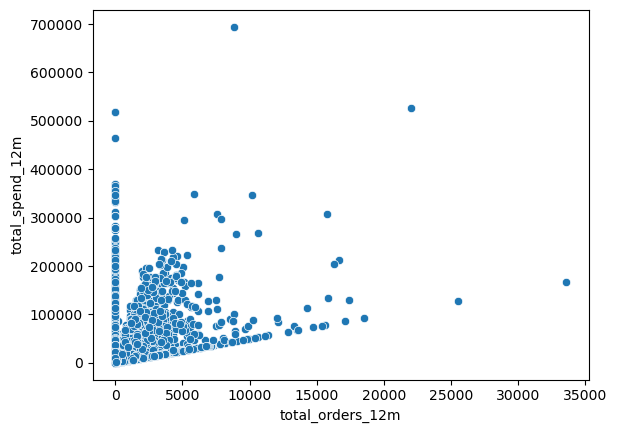

In [18]:
sns.scatterplot(df, x='total_orders_12m', y='total_spend_12m')

In [19]:
zero_orders = df[df['total_orders_12m']==0]
print(f"{(len(zero_orders) / len(df)) * 100:.2f}% of data says zero orders made over last 12m")

59.72% of data says zero orders made over last 12m


In [20]:
zero_orders.describe()
# how can there be people with 0 orders in past 12m but have spend in past 12m
# sessions_90d also appear with zeros even though days since last purchase was within 90days

,customer_id,recency_days,total_spend_12m,avg_basket_value,sessions_90d,days_since_last_purchase,items_per_order,loyalty_points,returns_12m,site_search_rate,email_open_rate,discount_pct_last_order,total_orders_12m,avg_time_between_orders,clv_3yr_usd
count,179159.000000,179159.000000,179159.000000,179159.000000,179159.0,179159.000000,179159.000000,179159.000000,179159.000000,179159.000000,179159.000000,179159.000000,179159.0,179159.000000,179159.000000
mean,150011.618691,1036.145418,6198.242411,50.074550,0.0,29.968185,4.000262,499.992297,2.001541,0.285746,0.276281,9.997774,0.0,13.087899,6891.474012
std,86665.312715,527.931564,11205.858947,19.807889,0.0,29.962187,1.728520,22.287970,1.417776,0.159920,0.155704,4.954846,0.0,11.278860,12337.478423
min,2.000000,366.000000,9.840000,5.000000,0.0,0.000000,1.000000,411.000000,0.000000,0.000289,0.000000,0.000000,0.0,0.100000,116.630000
25%,74912.500000,597.000000,1320.435000,36.500000,0.0,9.000000,3.000000,485.000000,1.000000,0.161160,0.169303,6.533690,0.0,6.180000,1561.135000
50%,149973.000000,910.000000,2967.120000,50.010000,0.0,21.000000,4.000000,500.000000,2.000000,0.264902,0.271151,9.956131,0.0,10.060000,3365.620000
75%,225136.000000,1374.000000,6701.575000,63.480000,0.0,41.000000,5.000000,515.000000,3.000000,0.389682,0.380146,13.367898,0.0,16.240000,7445.005000
max,299999.000000,2711.000000,518341.370000,135.570000,0.0,412.000000,14.000000,599.000000,11.000000,0.932675,0.927149,33.240327,0.0,172.940000,611839.570000


In [21]:
# if you boolean and cluster the values between people who had orders vs those who don't, do you see a difference
def tot_orders_check(data):
    if data == 0:
        return True
    else:
        return False

df['bool_tot_orders'] = df['total_orders_12m'].apply(tot_orders_check)

df['bool_tot_orders'].value_counts() / len(df['total_orders_12m'])

bool_tot_orders
True     0.597197
False    0.402803
Name: count, dtype: float64

<Axes: xlabel='total_spend_12m', ylabel='recency_days'>

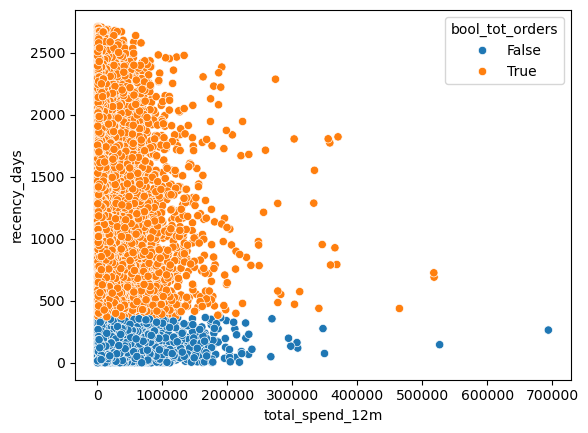

In [22]:
sns.scatterplot(df, x='total_spend_12m', y='recency_days', hue='bool_tot_orders')

In [29]:
desc_ex(zero_orders)

,customer_id,recency_days,total_spend_12m,avg_basket_value,sessions_90d,days_since_last_purchase,items_per_order,loyalty_points,returns_12m,site_search_rate,email_open_rate,discount_pct_last_order,total_orders_12m,avg_time_between_orders,clv_3yr_usd
count,179159.000000,179159.000000,179159.000000,179159.000000,179159.0,179159.000000,179159.000000,179159.000000,179159.000000,179159.000000,179159.000000,179159.000000,179159.0,179159.000000,179159.000000
mean,150011.618691,1036.145418,6198.242411,50.074550,0.0,29.968185,4.000262,499.992297,2.001541,0.285746,0.276281,9.997774,0.0,13.087899,6891.474012
std,86665.312715,527.931564,11205.858947,19.807889,0.0,29.962187,1.728520,22.287970,1.417776,0.159920,0.155704,4.954846,0.0,11.278860,12337.478423
min,2.000000,366.000000,9.840000,5.000000,0.0,0.000000,1.000000,411.000000,0.000000,0.000289,0.000000,0.000000,0.0,0.100000,116.630000
25%,74912.500000,597.000000,1320.435000,36.500000,0.0,9.000000,3.000000,485.000000,1.000000,0.161160,0.169303,6.533690,0.0,6.180000,1561.135000
50%,149973.000000,910.000000,2967.120000,50.010000,0.0,21.000000,4.000000,500.000000,2.000000,0.264902,0.271151,9.956131,0.0,10.060000,3365.620000
75%,225136.000000,1374.000000,6701.575000,63.480000,0.0,41.000000,5.000000,515.000000,3.000000,0.389682,0.380146,13.367898,0.0,16.240000,7445.005000
max,299999.000000,2711.000000,518341.370000,135.570000,0.0,412.000000,14.000000,599.000000,11.000000,0.932675,0.927149,33.240327,0.0,172.940000,611839.570000
median,149973.000000,910.000000,2967.120000,50.010000,0.0,21.000000,4.000000,500.000000,2.000000,0.264902,0.271151,9.956131,0.0,10.060000,3365.620000
skewness,0.000491,0.807466,9.282670,0.074064,0.0,2.009504,0.566237,0.048521,0.704915,0.595940,0.204350,0.122252,0.0,3.017643,9.586620


In [30]:
df_num['bool_tot_orders'] = df['bool_tot_orders']

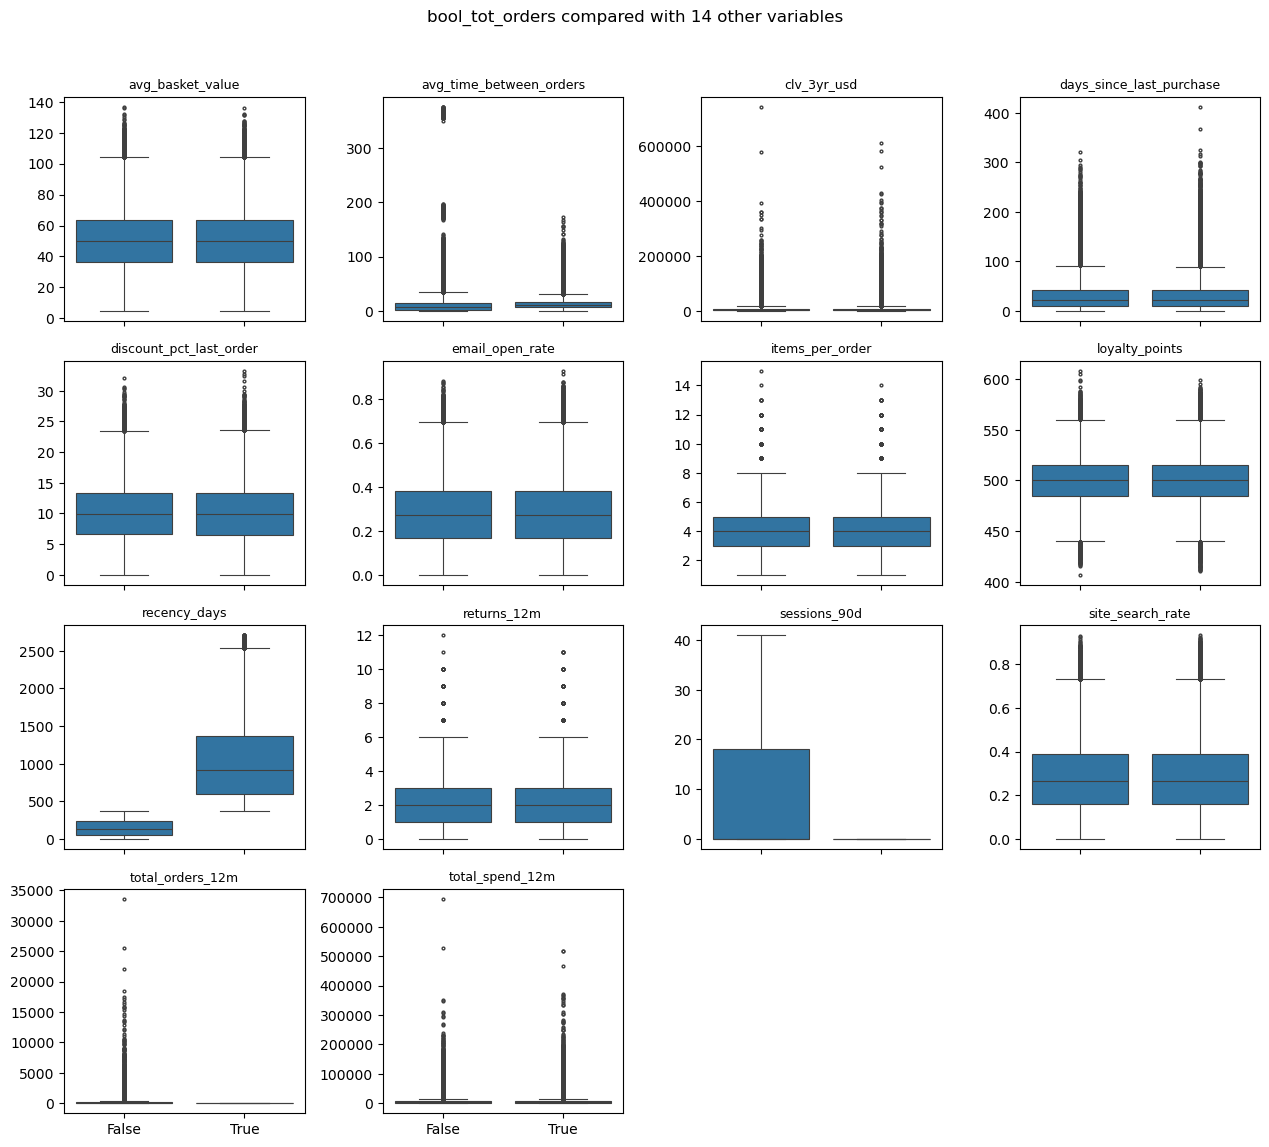

In [31]:
# bivariate analysis to see if there is a visual difference in users that have null avg time between orders
import math

focus = 'bool_tot_orders'
others = df.drop(columns=['customer_id'], axis=1).select_dtypes(include='number').columns.difference([focus])
n_panels = len(others)


n_cols = 4
n_rows = math.ceil(n_panels / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                          figsize=(3.2*n_cols, 2.8*n_rows),
                          sharex=True,  sharey=False)
axes = axes.flatten()


for ax, col in zip(axes, others):
    sns.boxplot(data=df, x=focus, y=col,
                orient='v', ax=ax, fliersize=2, linewidth=.8)
    ax.set_title(col, fontsize=9)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=0)


for extra in axes[n_panels:]:
    extra.set_visible(False)

fig.suptitle(f'{focus} compared with {n_panels} other variables',
             fontsize=12, y=1.02)
fig.tight_layout()
plt.show()


In [32]:
binned_data = pd.cut(df['total_orders_12m'], bins=5)

In [33]:
binned_data.value_counts().sort_index()

total_orders_12m
(-33.567, 6713.4]     299927
(6713.4, 13426.8]         57
(13426.8, 20140.2]        13
(20140.2, 26853.6]         2
(26853.6, 33567.0]         1
Name: count, dtype: int64

In [34]:
MAD_total_spend_12m = remove_outliers_mad(df, 'total_spend_12m')

MAD_total_spend_12m

has_orders = MAD_total_spend_12m[MAD_total_spend_12m['total_orders_12m']>0]

In [35]:
has_orders

,customer_id,signup_date,last_activity_ts,recency_days,total_spend_12m,avg_basket_value,sessions_90d,days_since_last_purchase,items_per_order,loyalty_points,...,preferred_device,country_code,customer_segment,primary_browser,next_product_cat,clv_3yr_usd,date_pulled,bool_ATBO,region_name,bool_tot_orders
0,1,2023-01-27,2025-04-16 01:58:26.529018164,57,4174.02,30.83,22,18,3,489.0,...,SmartTV,GB,Segment_9,Browser_13,Apparel,4948.64,2025-06-13,False,Europe,False
5,6,2023-04-15,2025-01-25 23:08:27.521924972,138,2046.53,46.96,0,9,9,511.0,...,Desktop,US,Segment_2,Browser_19,Apparel,2480.54,2025-06-13,False,Americas,False
6,7,2025-06-06,2025-06-11 16:30:49.290670395,1,5617.58,77.60,20,39,7,502.0,...,SmartTV,JP,Segment_9,Browser_11,Apparel,6511.27,2025-06-13,False,Asia,False
9,10,2024-08-19,2024-12-06 20:14:09.736309767,188,4509.11,57.90,0,4,6,494.0,...,Mobile,SA,Segment_2,Browser_23,Beauty,5349.59,2025-06-13,False,Asia,False
10,11,2024-05-15,2025-05-06 10:46:46.823778391,37,7511.92,62.47,18,18,4,503.0,...,Desktop,AT,Segment_6,Browser_14,Sports,8351.94,2025-06-13,False,Europe,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299991,299992,2024-10-19,2025-05-10 11:30:57.115020752,33,2913.49,80.52,26,6,5,504.0,...,Other,US,Segment_17,Browser_17,Beauty,3667.93,2025-06-13,False,Americas,False
299994,299995,2025-01-24,2025-05-27 08:08:08.883556843,16,299.15,75.59,24,51,5,452.0,...,Tablet,CN,Segment_12,Browser_12,Sports,513.21,2025-06-13,False,Asia,False
299995,299996,2025-05-12,2025-05-17 08:28:50.901688576,26,5703.07,34.11,15,37,5,528.0,...,SmartTV,NL,Segment_18,Browser_3,Beauty,6893.14,2025-06-13,False,Europe,False
299996,299997,2020-06-17,2025-02-11 19:53:32.808164597,121,3522.56,56.41,0,4,1,532.0,...,Desktop,IE,Segment_17,Browser_8,Beauty,3949.57,2025-06-13,False,Europe,False


In [36]:
desc_ex(has_orders)

,customer_id,recency_days,total_spend_12m,avg_basket_value,sessions_90d,days_since_last_purchase,items_per_order,loyalty_points,returns_12m,site_search_rate,email_open_rate,discount_pct_last_order,total_orders_12m,avg_time_between_orders,clv_3yr_usd
count,99504.000000,99504.000000,99504.000000,99504.000000,99504.000000,99504.000000,99504.000000,99504.000000,99504.000000,99504.000000,99504.000000,99504.000000,99504.000000,99504.000000,99504.000000
mean,149955.987950,151.529325,2932.319556,50.046552,7.314279,29.954685,3.999226,499.871905,2.001156,0.285972,0.275588,10.002376,78.593765,15.289443,3375.965076
std,86566.868765,107.270638,2252.596965,19.821610,9.998668,29.765881,1.738468,22.330214,1.419713,0.160071,0.155423,4.937088,112.183647,25.058496,2486.652716
min,1.000000,0.000000,14.430000,5.000000,0.000000,0.000000,1.000000,407.000000,0.000000,0.000331,0.000000,0.000000,1.000000,0.100000,124.090000
25%,74836.500000,55.000000,1115.667500,36.450000,0.000000,9.000000,3.000000,485.000000,1.000000,0.161293,0.169293,6.583746,23.000000,3.400000,1374.407500
50%,150160.500000,137.000000,2283.170000,49.880000,0.000000,21.000000,4.000000,500.000000,2.000000,0.264372,0.269606,9.987193,49.000000,8.800000,2659.545000
75%,224792.750000,239.000000,4273.657500,63.490000,18.000000,42.000000,5.000000,515.000000,3.000000,0.389322,0.379057,13.356444,96.000000,17.400000,4850.660000
max,300000.000000,365.000000,9107.210000,136.710000,41.000000,305.000000,13.000000,608.000000,12.000000,0.929458,0.882302,32.013161,1817.000000,376.400000,11389.170000
median,150160.500000,137.000000,2283.170000,49.880000,0.000000,21.000000,4.000000,500.000000,2.000000,0.264372,0.269606,9.987193,49.000000,8.800000,2659.545000
skewness,-0.001982,0.329290,0.905320,0.081447,0.782463,1.944607,0.586681,0.049997,0.726574,0.600350,0.204289,0.110810,6.174405,6.439176,0.917931


In [37]:
has_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99504 entries, 0 to 299999
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99504 non-null  int64  
 1   signup_date               99504 non-null  object 
 2   last_activity_ts          99504 non-null  object 
 3   recency_days              99504 non-null  int64  
 4   total_spend_12m           99504 non-null  float64
 5   avg_basket_value          99504 non-null  float64
 6   sessions_90d              99504 non-null  int64  
 7   days_since_last_purchase  99504 non-null  int64  
 8   items_per_order           99504 non-null  int64  
 9   loyalty_points            99504 non-null  float64
 10  returns_12m               99504 non-null  int64  
 11  site_search_rate          99504 non-null  float64
 12  email_open_rate           99504 non-null  float64
 13  discount_pct_last_order   99504 non-null  float64
 14  total_orde

In [38]:
has_orders['customer_segment'].value_counts()

customer_segment
Segment_9     5133
Segment_14    5077
Segment_16    5056
Segment_19    5054
Segment_6     5036
Segment_10    5003
Segment_2     5000
Segment_1     4999
Segment_13    4991
Segment_4     4968
Segment_11    4962
Segment_3     4953
Segment_20    4939
Segment_17    4929
Segment_18    4925
Segment_7     4922
Segment_5     4907
Segment_12    4898
Segment_8     4893
Segment_15    4859
Name: count, dtype: int64

In [45]:
pd.crosstab(index=df['customer_segment'], columns=df['region_name'])

region_name,Africa,Americas,Asia,Europe,Oceania
customer_segment,,,,,
Segment_1,489,2053,4032,7591,974
Segment_10,541,1898,3954,7539,999
Segment_11,504,2058,3896,7348,1001
Segment_12,531,1993,4005,7513,1002
Segment_13,500,2019,4021,7428,1002
Segment_14,505,1984,4077,7591,1008
Segment_15,505,1965,3947,7524,1002
Segment_16,494,2006,4112,7518,972
Segment_17,516,1955,4007,7607,1032


In [40]:
df.isna().sum()

customer_id                 0
signup_date                 0
last_activity_ts            0
recency_days                0
total_spend_12m             0
avg_basket_value            0
sessions_90d                0
days_since_last_purchase    0
items_per_order             0
loyalty_points              0
returns_12m                 0
site_search_rate            0
email_open_rate             0
discount_pct_last_order     0
total_orders_12m            0
avg_time_between_orders     0
is_premium_member           0
marketing_opt_in            0
preferred_device            0
country_code                0
customer_segment            0
primary_browser             0
next_product_cat            0
clv_3yr_usd                 0
date_pulled                 0
bool_ATBO                   0
region_name                 0
bool_tot_orders             0
dtype: int64

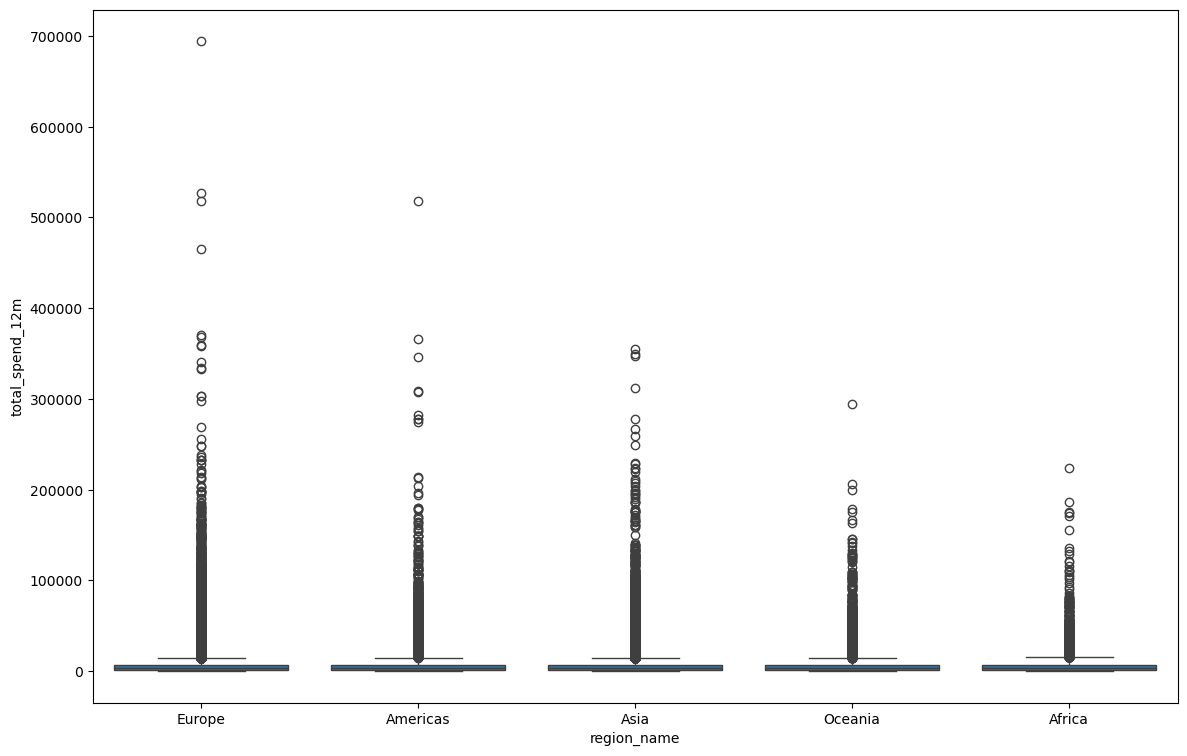

In [41]:
plt.figure(figsize=[14,9])
sns.boxplot(data=df, y='total_spend_12m', x='region_name')
plt.show()

In [29]:
round(pd.crosstab(index=df['is_premium_member'], columns=df['preferred_device'], normalize='columns')*100,2)

preferred_device,Desktop,Mobile,Other,SmartTV,Tablet
is_premium_member,,,,,
No,80.16,80.0,79.87,80.14,80.01
Yes,19.84,20.0,20.13,19.86,19.99


In [31]:
round(pd.crosstab(index=df['marketing_opt_in'], columns=df['region_name'], normalize='columns')*100,2)

region_name,Africa,Americas,Asia,Europe,Oceania
marketing_opt_in,,,,,
No,40.12,40.42,39.91,40.27,39.93
Yes,59.88,59.58,60.09,59.73,60.07


In [52]:
pd.crosstab(index=has_orders['preferred_device'], columns=has_orders['region_name'], normalize='columns')

region_name,Africa,Americas,Asia,Europe,Oceania
preferred_device,,,,,
Desktop,0.209058,0.206014,0.197290,0.201089,0.198962
Mobile,0.197660,0.198934,0.201333,0.204143,0.198504
Other,0.202160,0.193529,0.198226,0.199883,0.198046
SmartTV,0.200960,0.200990,0.201445,0.198055,0.202779
Tablet,0.190162,0.200533,0.201707,0.196830,0.201710


In [51]:
pd.crosstab(index=has_orders['is_premium_member'], columns=has_orders['region_name'], normalize='columns')

region_name,Africa,Americas,Asia,Europe,Oceania
is_premium_member,,,,,
No,0.796641,0.80434,0.798555,0.79865,0.803176
Yes,0.203359,0.19566,0.201445,0.20135,0.196824


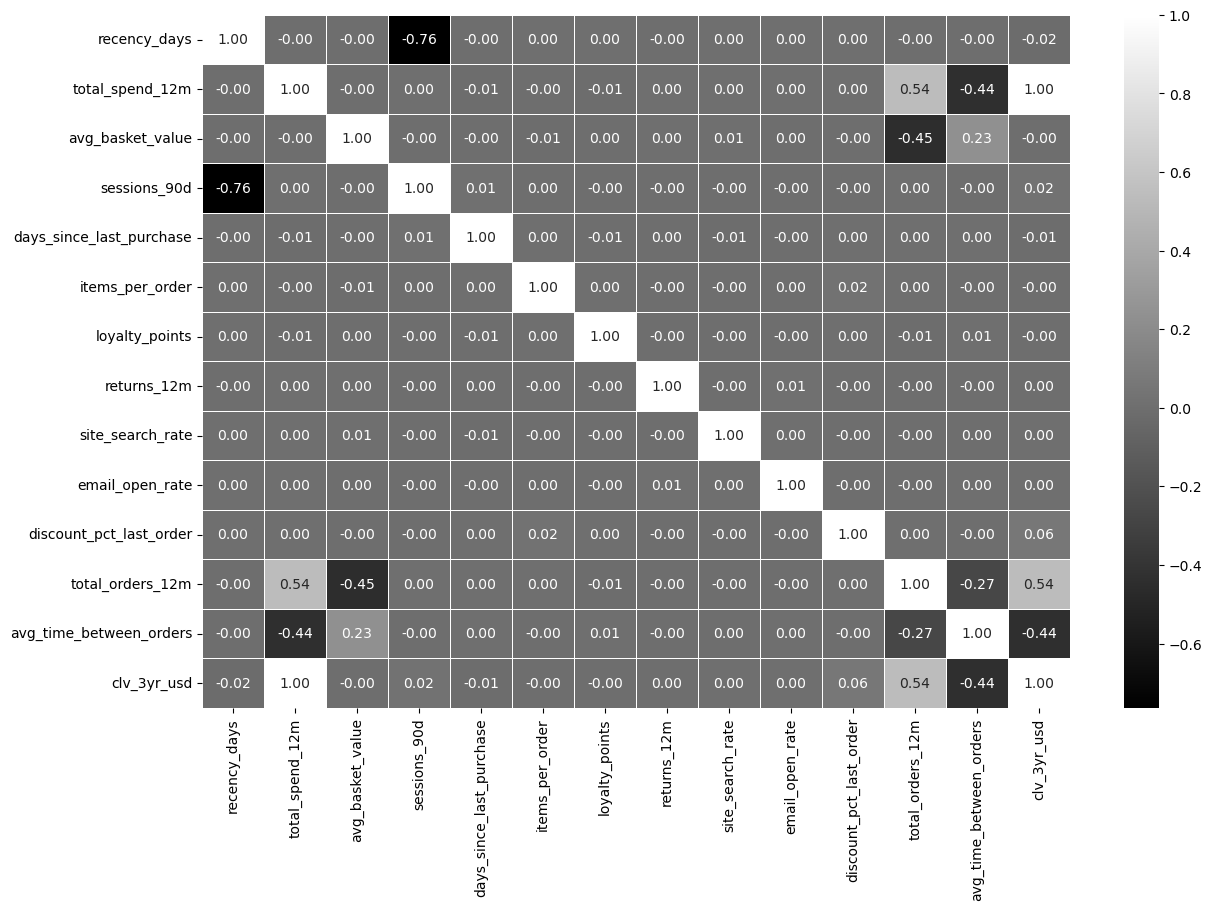

In [44]:
corr_matrix = has_orders.select_dtypes(include='number')
corr_matrix = corr_matrix.drop(columns=['customer_id'])
corr_matrix = corr_matrix.corr()

plt.figure(figsize=wide_plt)
sns.heatmap(corr_matrix, annot=True, cmap='gray', fmt='.2f', linewidth=.5)
plt.show()
